# Inversion with a configuration file

In this notebook we show how to use a configuration file to run Hazel in different situations for inverting Stokes profiles.

## On-disk inversions
Let's first a set of observations obtained from the GREGOR telescope as example. The observations consisted of a scan of an active region in which filaments are seen when observed in the core of the He I 10830 A line. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
import scipy.io as io
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/Dropbox/GIT/hazel2/hazel/io.py:12: UserWarning: zarr module not found. You will not be able to use zarr as input/output.
  warnings.warn("zarr module not found. You will not be able to use zarr as input/output.")


2018.06.07


First read the observations and do some plots. The wavelength axis in the save file is given in displacement with respect to some reference wavelength, in this case 10830.0911 A.

dict_keys(['heperf', 'lambda'])
210


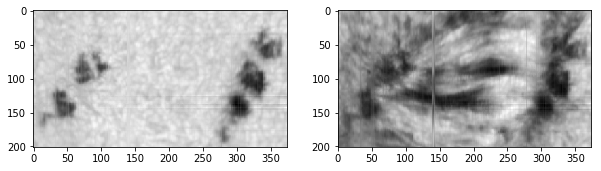

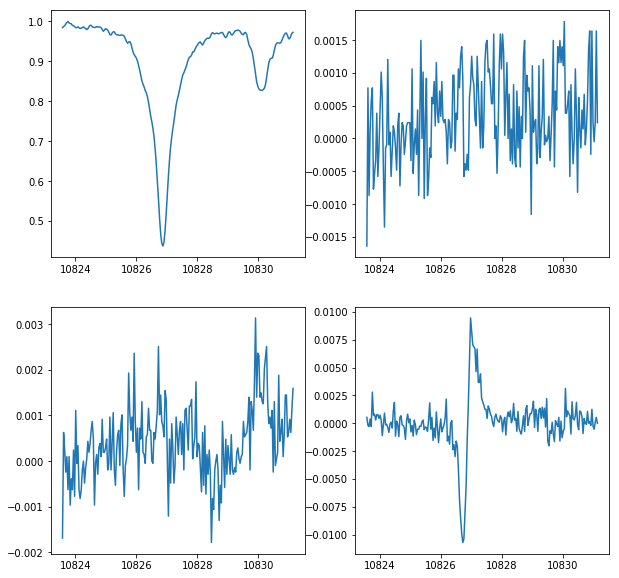

In [4]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/gregor_spot.sav')
print(tmp.keys())
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,181])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,210))
stokes[0,:] = tmp['heperf'][160,0,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[1,:] = tmp['heperf'][160,1,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[2,:] = tmp['heperf'][160,2,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[3,:] = tmp['heperf'][160,3,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
ax[0,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[0,:])
ax[0,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[1,:])
ax[1,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[2,:])
ax[1,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[3,:])

wvl = tmp['lambda'][0:-40]
stokes = stokes[:,:]
n_lambda = len(wvl)
print(n_lambda)

Now we save 1D files for the inversion. First the wavelength axis:

In [3]:
np.savetxt('10830_spot.wavelength', wvl+10830.0911, header='lambda')

Then, let's assume that we weight all wavelengths equally:

In [4]:
f = open('10830_spot.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_lambda):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
stokes.shape

(4, 210)

Finally, let's compute a very rough estimation of the noise standard deviation and save the Stokes parameters in a file, that we also print so that you can check the required format.

In [5]:
noise = np.std(stokes[1,0:20])
f = open('10830_spot_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,n_lambda))])
np.savetxt(f, tmp.T)
f.close()

%cat 10830_spot_stokes.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
0.0 0.0 90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
1.0 0.0 0.0 0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
9.844778180122375488e-01 -1.641324721276760101e-03 -1.689598895609378815e-03 5.310168489813804626e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.873363971710205078e-01 7.723881280981004238e-04 6.275653140619397163e-04 -1.930970320245251060e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.892690181732177734e-01 -8.689365931786596775e-04 2.413712936686351895e-04 -2.896455407608300447e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.933860301971435547e-01 1.448227703804150224e-04 -2.413712936686351895e-04 3.861940640490502119e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.975462555885314

So we are now ready for the inversion. Let's print first the configuration file and then do a simple inversion for a 1D input file. You can see that we are including two atmospheres, a photosphere to explain the Si I line and a chromosphere to explain the He I multiplet. We also give some rough intervals for the parameters.

In [6]:
%cat conf_spot.ini

cat: conf_spot.ini: No such file or directory


In [2]:
mod = hazel.Model('../configuration/conf_spot.ini', working_mode='inversion', verbose=3)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-01 09:40:36,005 - Adding spectral region spec1
2018-10-01 09:40:36,006 -   - Reading wavelength axis from 10830_spot.wavelength
2018-10-01 09:40:36,010 -   - Reading wavelength weights from 10830_spot.weights
2018-10-01 09:40:36,017 -   - Using observations from 10830_spot_stokes.1d
2018-10-01 09:40:36,020 -   - No mask for pixels
2018-10-01 09:40:36,021 -   - No instrumental profile
2018-10-01 09:40:36,023 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-01 09:40:36,024 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-01 09:40:36,026 - Using 2 cycles
2018-10-01 09:40:36,027 - Not using randomizations
2018-10-01 09:40:36,030 - Adding atmospheres
2018-10-01 09:40:36,031 -   - New available chromosphere : ch1
2018-10-01 09:40:36,034 -     * Adding line : 10830
2018-10-01 09:40:36,035 -     * Magnetic field reference frame : vertical
2018-10-01 09:40:36,037 -     * Reading 1D model ../models/chromospheres/model_spicules.1d as reference
2018-10-01 09:40:36,040 -   

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.287    -1.554    11.227     1.000     0.049


2018-10-01 09:40:38,973 -   * Optimal lambda: 0.047738022520411386
2018-10-01 09:40:39,072 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:39,142 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:39,163 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:39,187 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:39,211 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:39,316 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:39,403 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:39,490 - It: 1 - chi2: 336.3406060580626 - lambda: 0.047738022520411386 - rel: -0.7261017244950965


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.258    -4.166    11.836     1.000     0.004


2018-10-01 09:40:39,827 -   * Optimal lambda: 0.6526193270009302
2018-10-01 09:40:39,911 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:39,979 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:39,997 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:40,020 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:40,045 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:40,158 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:40,232 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:40,318 - It: 2 - chi2: 294.7561812055451 - lambda: 0.6526193270009302 - rel: -0.13178461906873173


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.272    -4.446    11.418     1.000     0.020


2018-10-01 09:40:40,866 -   * Optimal lambda: 0.22842687086599636
2018-10-01 09:40:40,948 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:41,010 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:41,031 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:41,053 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:41,081 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:41,181 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:41,293 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:41,444 - It: 3 - chi2: 273.3353372391663 - lambda: 0.22842687086599636 - rel: -0.0754133560206059


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.286    -4.607    10.517     1.000     0.089


2018-10-01 09:40:42,422 -   * Optimal lambda: 0.02284268708659963
2018-10-01 09:40:42,507 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:42,576 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:42,602 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:42,624 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:42,651 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:42,746 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:42,833 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:42,906 - It: 4 - chi2: 246.04596674462627 - lambda: 0.02284268708659963 - rel: -0.10508414640736309


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.298    -4.710     7.561     1.000     0.100


2018-10-01 09:40:43,739 -   * Optimal lambda: 0.002284268708659962
2018-10-01 09:40:43,824 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:43,888 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:43,908 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:43,930 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:43,957 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:44,057 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:44,142 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:44,246 - It: 5 - chi2: 157.5015071012837 - lambda: 0.002284268708659962 - rel: -0.4388304493619617


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.292    -5.115     8.929     1.000     0.100


2018-10-01 09:40:45,191 -   * Optimal lambda: 0.0007223491907217069
2018-10-01 09:40:45,291 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:45,375 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:45,402 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:45,427 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:45,452 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:45,561 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:45,649 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:45,773 - It: 6 - chi2: 154.63364690076676 - lambda: 0.0007223491907217069 - rel: -0.018375759114259142


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.290    -4.976     8.702     1.000     0.100


2018-10-01 09:40:46,817 -   * Optimal lambda: 0.0007223491907217067
2018-10-01 09:40:46,901 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:46,984 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:47,019 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:47,045 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:47,073 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:47,205 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:47,314 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:47,402 - It: 7 - chi2: 154.59537457584796 - lambda: 0.0007223491907217067 - rel: -0.00024753384877041255


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.290    -5.014     8.687     1.000     0.100


2018-10-01 09:40:47,651 -   * Optimal lambda: 0.028711039870063838
2018-10-01 09:40:47,753 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:47,844 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:47,874 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:47,905 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:47,934 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:48,038 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:48,124 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:48,216 - It: 8 - chi2: 154.59542049443897 - lambda: 0.028711039870063838 - rel: 2.97024308260322e-07


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:48,317 -  * RF to T - ph1 - nodes=3
2018-10-01 09:40:48,378 -  * RF to vmic - ph1 - nodes=1
2018-10-01 09:40:48,397 -  * RF to v - ph1 - nodes=1
2018-10-01 09:40:48,425 -  * RF to tau - ch1 - nodes=1
2018-10-01 09:40:48,458 -  * RF to v - ch1 - nodes=1
2018-10-01 09:40:48,580 -  * RF to deltav - ch1 - nodes=1
2018-10-01 09:40:48,675 -  * RF to a - ch1 - nodes=1
2018-10-01 09:40:48,788 - -------------
2018-10-01 09:40:48,788 -   Cycle 1  
2018-10-01 09:40:48,789 -   Weights for region spec1 : SI=0.1 - SQ=10.0 - SU=10.0 - SV=1.0
2018-10-01 09:40:48,790 - -------------
2018-10-01 09:40:48,791 - Free parameters for ch1
2018-10-01 09:40:48,793 -   - Bx with 1 node
2018-10-01 09:40:48,794 -   - By with 1 node
2018-10-01 09:40:48,795 -   - Bz with 1 node
2018-10-01 09:40:48,796 - Free parameters for ph1
2018-10-01 09:40:48,798 -   - Bz with 1 node
2018-10-01 09:40:48,914 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:48,958 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:49,04

     Bx        By        Bz        tau       v       deltav      beta      a
   5.360     6.349   -36.065     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:51,922 -   * Optimal lambda: 9.07922799813065
2018-10-01 09:40:51,972 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:52,020 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:52,169 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:52,337 -  * RF to Bz - ch1 - nodes=1
2018-10-01 09:40:52,493 - It: 1 - chi2: 21.736191902648077 - lambda: 9.07922799813065 - rel: -0.01756714742527813


     Bx        By        Bz        tau       v       deltav      beta      a
   9.866     7.480   -25.979     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:53,351 -   * Optimal lambda: 15.369558857122268
2018-10-01 09:40:53,482 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:53,538 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:53,690 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:53,863 -  * RF to Bz - ch1 - nodes=1
2018-10-01 09:40:53,992 - It: 2 - chi2: 21.627691516622598 - lambda: 15.369558857122268 - rel: -0.005004182165901793


     Bx        By        Bz        tau       v       deltav      beta      a
  11.021     7.821   -21.640     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:54,673 -   * Optimal lambda: 69.38989233095022
2018-10-01 09:40:54,818 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:54,875 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:55,023 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:55,170 -  * RF to Bz - ch1 - nodes=1
2018-10-01 09:40:55,307 - It: 3 - chi2: 21.61483962780165 - lambda: 69.38989233095022 - rel: -0.0005944096462819638


     Bx        By        Bz        tau       v       deltav      beta      a
  11.175     7.841   -20.396     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:56,107 -   * Optimal lambda: 110.1811707966659
2018-10-01 09:40:56,259 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:56,302 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:56,479 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:56,617 -  * RF to Bz - ch1 - nodes=1
2018-10-01 09:40:56,732 - It: 4 - chi2: 21.611239914525964 - lambda: 110.1811707966659 - rel: -0.00016655284558767235


     Bx        By        Bz        tau       v       deltav      beta      a
  11.237     7.842   -19.683     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:57,349 -   * Optimal lambda: 153.52725310250062
2018-10-01 09:40:57,458 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:57,500 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:57,617 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:57,722 -  * RF to Bz - ch1 - nodes=1
2018-10-01 09:40:57,821 - It: 5 - chi2: 21.610565385140724 - lambda: 153.52725310250062 - rel: -3.121245771957193e-05


     Bx        By        Bz        tau       v       deltav      beta      a
  11.264     7.836   -19.400     0.290    -5.016     8.676     1.000     0.100


2018-10-01 09:40:57,955 -  * RF to Bz - ph1 - nodes=1
2018-10-01 09:40:58,013 -  * RF to Bx - ch1 - nodes=1
2018-10-01 09:40:58,167 -  * RF to By - ch1 - nodes=1
2018-10-01 09:40:58,308 -  * RF to Bz - ch1 - nodes=1


NWe see that we found a solution with a relatively good $\chi^2$ and now let's analyze the results. For your specific case, you probably need some trial and error on the Stokes weights and range of parameters to find a reliable solution.

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 2, 4, 210)


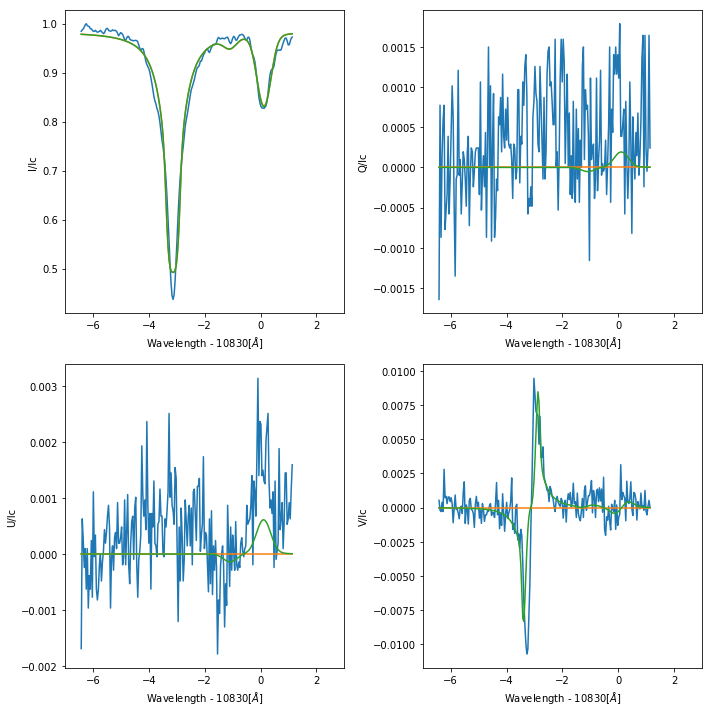

In [5]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(2):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-7,3])
    
pl.tight_layout()

f.close()

Now the photospheric model:

(npix,nrand,ncycle,nz) -> (1, 1, 2, 73)


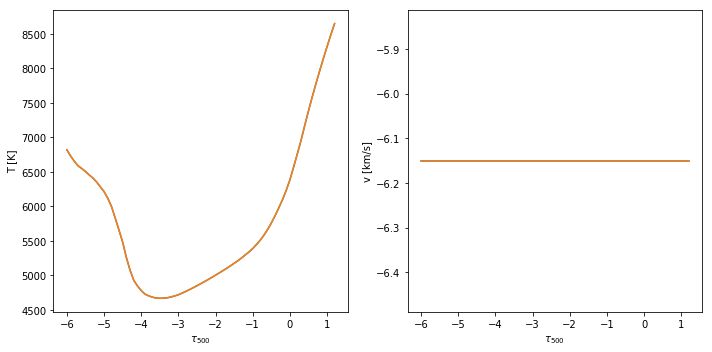

In [6]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nz) -> {0}'.format(f['ph1']['T'].shape))

fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.flatten()
for i in range(2):
    ax[0].plot(f['ph1']['log_tau'][:], f['ph1']['T'][0,0,i,:])    
    
for i in range(2):
    ax[1].plot(f['ph1']['log_tau'][:], f['ph1']['v'][0,0,i,:])

ax[0].set_xlabel(r'$\tau_{500}$')
ax[0].set_ylabel('T [K]')

ax[1].set_xlabel(r'$\tau_{500}$')
ax[1].set_ylabel('v [km/s]')
    
pl.tight_layout()

f.close()

## Spicules
Let's try to invert observations from spicules. First, we read the observations from the datafile (already on the correct reference system and with the wavelength calibration).

dict_keys(['lambda', 'heperf', 'mask_heights'])
(25, 4, 224, 101)


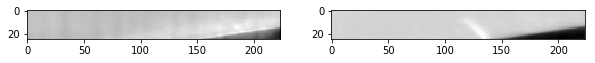

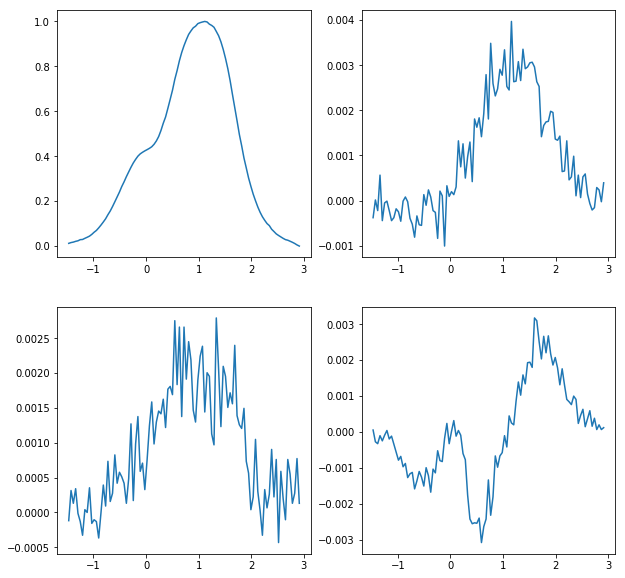

In [7]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/Spiculas_map.sav')
print(tmp.keys())
print(tmp['heperf'].shape)
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,100])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,101))
stokes[0,:] = tmp['heperf'][10,0,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[1,:] = tmp['heperf'][10,1,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[2,:] = tmp['heperf'][10,2,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[3,:] = tmp['heperf'][10,3,175,:] / np.max(tmp['heperf'][10,0,175,:])
ax[0,0].plot(tmp['lambda'], stokes[0,:])
ax[0,1].plot(tmp['lambda'], stokes[1,:])
ax[1,0].plot(tmp['lambda'], stokes[2,:])
ax[1,1].plot(tmp['lambda'], stokes[3,:])

The first thing we do is estimate the noise standard deviation. You should do it more carefully so that the final values of the $\chi^2$ are close to one in case the observed profile can be correctly represented with the simple Hazel atmosphere. For the moment and as a quick estimation we just estimate it via the standard deviation in a small region close to the continuum.

In [8]:
noise=np.std(stokes[1,0:15])
print(noise)

0.00026189987900385165


Then we save several files with the observations. The first one the file with the wavelength axis. Remember that this axis is common to all observed pixels in case HDF5 files are used. We add 10829.0911 Angstrom because the osberved files are referred to this wavelength (it is the center of the multiplet).

In [9]:
np.savetxt('10830_spicules.wavelength', tmp['lambda']+10829.0911, header='lambda')

Then we save a file with the wavelength weights. For the moment, let's just weight all of them equally.

In [10]:
f = open('10830_spicules.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(101):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
stokes.shape

(4, 101)

And finally we save the file with the observed Stokes profile, following the manual.

In [11]:
f = open('10830_spicules_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,101))])
np.savetxt(f, tmp.T)
f.close()

%cat 10830_spicules_stokes.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
90.0 0.0 90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
0.0 0.0 0.0 0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
1.065849605947732925e-02 -3.797253011725842953e-04 -1.178457823698408902e-04 5.237590085016563535e-05 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.414149347692728043e-02 1.309397521254140884e-05 3.142554196529090405e-04 -2.749734849203377962e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.621034182608127594e-02 -2.225975767942145467e-04 1.309397484874352813e-04 -3.273493784945458174e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.961477473378181458e-02 5.630409577861428261e-04 3.404433664400130510e-04 -1.047518017003312707e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
2.19978783279657

We print now the configuration file used in this case. Note that we do two cycles: the first one is used to estimate parameters from Stokes $I$ while the second one is used to get information from the magnetic field. Some trial-and-error is necessary for setting up the weights. Also note that we fix the height to 3''. One should measure this number better in the observations and set it appropriately.

In [25]:
%cat conf_spicules.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 2

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    #Wavelength = 10826, 10833, 150
    Topology = ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 90.0, 0.0, 90.0
    Boundary condition = 0.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spicules.wavelength'
    Wavelength weight file = '10830_spicules.weights'
    Observations file = '10830_spicules_stokes.1d'    
    Weights Stokes I = 1.0, 0.1, 0.0, 0.0
    Weights Stokes Q = 0.0, 10.0, 0.0, 0.0
    Weights Stokes U = 0.0, 10.0, 0.0, 0.0
    Weights Stokes V = 0.0, 1.0, 0.0, 0.0
    Mask file = None

[Atmosph

Finally, let's carry out the inversion. We activate verbosity to analyze the inversion.

In [17]:
mod = hazel.Model('../configuration/conf_spicules.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-01 09:45:54,385 - Adding spectral region spec1
2018-10-01 09:45:54,385 -   - Reading wavelength axis from 10830_spicules.wavelength
2018-10-01 09:45:54,389 -   - Reading wavelength weights from 10830_spicules.weights
2018-10-01 09:45:54,398 -   - Using observations from 10830_spicules_stokes.1d
2018-10-01 09:45:54,402 -   - No mask for pixels
2018-10-01 09:45:54,404 -   - No instrumental profile
2018-10-01 09:45:54,406 -   - Using LOS ['90.0', '0.0', '90.0']
2018-10-01 09:45:54,407 -   - Using off-limb normalization (peak intensity)
2018-10-01 09:45:54,408 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2018-10-01 09:45:54,409 - Using 3 cycles
2018-10-01 09:45:54,410 - Not using randomizations
2018-10-01 09:45:54,411 - Adding atmospheres
2018-10-01 09:45:54,412 -   - New available chromosphere : ch1
2018-10-01 09:45:54,413 -     * Adding line : 10830
2018-10-01 09:45:54,417 -     * Magnetic field reference frame : vertical
2018-10-01 09:45:54,419 -     * Reading 1D 

After some seconds, we end up with the following fit:

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 3, 4, 101)


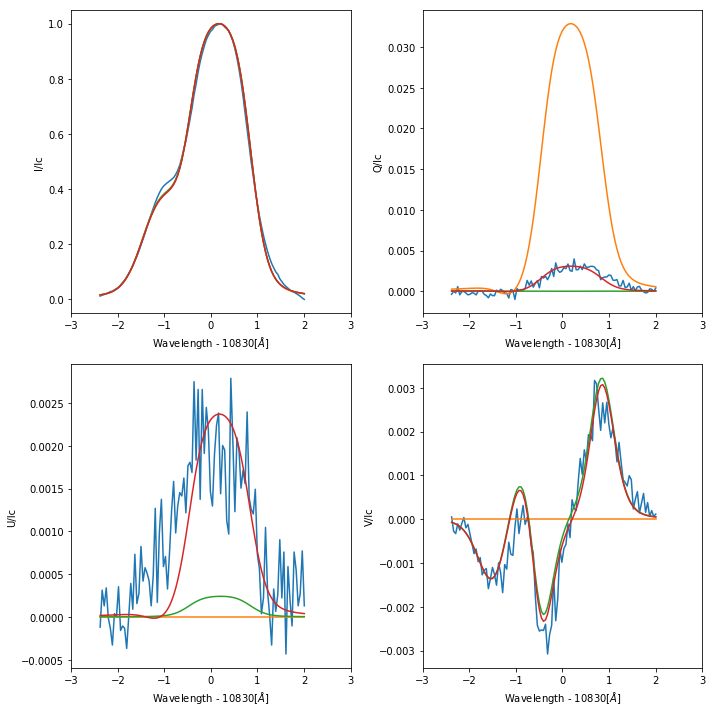

In [18]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(3):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-3,3])
    
pl.tight_layout()

f.close()